## Random Acts of Pizza
The Random Acts of Pizza subreddit is a place where people post and request free pizza from others on the Internet. In this Kaggle competition, the objective is to create a model that predicts whether or not a request will receive pizza using the provided dataset of 5671 requests collected from the Reddit community ‘Random Acts of Pizza’ between December 8, 2010 and September 29, 2013. We use the RAOP train and test dataset for the same. It contains 5671 textual requests for pizza from the Reddit community together with their outcome (successful/unsuccessful) and meta-data. All requests ask for the same thing: a free pizza. The outcome of each request -- whether its author received a pizza or not -- is known. Meta-data includes information such as: time of the request, activity of the requester, community-age of the requester, etc. We will create an algorithm capable of predicting which requests will garner a cheesy (but sincere!) act of kindness. However, the test dataset does not contain fields which would not be available at the time of posting.

In [3]:
#Import the required modules

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # Allows the use of display() for DataFrames

import unicodedata
import sys

from sklearn import grid_search, cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import scipy as scipy

import time

import warnings
warnings.filterwarnings('ignore')

In [4]:
## Import RAOP train and test dataset
import pandas as pd
train = pd.read_json("train.json")
test = pd.read_json("test.json")
print(len(train),len(test))

4040 1631


Check for missing values

In [25]:
train.isnull().sum()  ##Check for null values

giver_username_if_known                                    0
number_of_downvotes_of_request_at_retrieval                0
number_of_upvotes_of_request_at_retrieval                  0
post_was_edited                                            0
request_id                                                 0
request_number_of_comments_at_retrieval                    0
request_text                                               0
request_text_edit_aware                                    0
request_title                                              0
requester_account_age_in_days_at_request                   0
requester_account_age_in_days_at_retrieval                 0
requester_days_since_first_post_on_raop_at_request         0
requester_days_since_first_post_on_raop_at_retrieval       0
requester_number_of_comments_at_request                    0
requester_number_of_comments_at_retrieval                  0
requester_number_of_comments_in_raop_at_request            0
requester_number_of_comm

We look at the dataset in greater detail to see how many people have actually received the data, and what is the success rate

In [5]:
import random
ri = random.randint(0, len(train))
#print(train.iloc[ri])
got_pizza = train['requester_received_pizza'].value_counts()
print('\nCounts for sucessfull pizza aquisition:\n', got_pizza)
print('The average success rate is: %.3f%%' %((got_pizza[1]/(sum(got_pizza))*100)))


Counts for sucessfull pizza aquisition:
 False    3046
True      994
Name: requester_received_pizza, dtype: int64
The average success rate is: 24.604%


## Preprocessing of data
We segregate the continuous, text, time, and target fields and look at a correlation matrix to understand the correlations between different fields

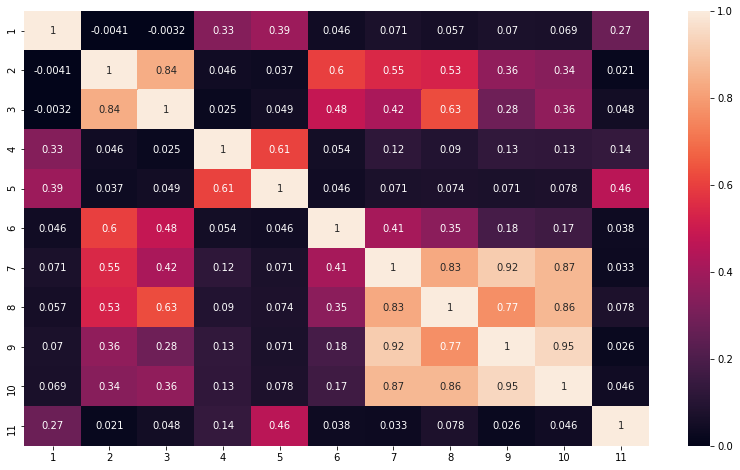

In [6]:
cont_features = ['number_of_downvotes_of_request_at_retrieval',
                 'number_of_upvotes_of_request_at_retrieval',
                 'request_number_of_comments_at_retrieval',
                 'requester_account_age_in_days_at_request',
                 'requester_account_age_in_days_at_retrieval',
                 'requester_days_since_first_post_on_raop_at_request',
                 'requester_days_since_first_post_on_raop_at_retrieval',
                 'requester_number_of_comments_at_request',
                 'requester_number_of_comments_at_retrieval',
                 'requester_number_of_comments_in_raop_at_request',
                 'requester_number_of_comments_in_raop_at_retrieval',
                 'requester_number_of_posts_at_request',
                 'requester_number_of_posts_at_retrieval',
                 'requester_number_of_posts_on_raop_at_request',
                 'requester_number_of_posts_on_raop_at_retrieval',
                 'requester_number_of_subreddits_at_request',
                 'requester_upvotes_minus_downvotes_at_request',
                 'requester_upvotes_minus_downvotes_at_retrieval',
                 'requester_upvotes_plus_downvotes_at_request',
                 'requester_upvotes_plus_downvotes_at_retrieval']
                
text_features = ['request_title',
                 'request_text_edit_aware',
                 'request_text']

time_features_names = ['unix_timestamp_of_request',
                 'unix_timestamp_of_request_utc']
    
target = 'requester_received_pizza'

feats = ['1','2','3','4','5','6','7','8','9','10','11']
df_cont_small = train[cont_features[-10:]]
correlations_small = df_cont_small.join(train[target]).corr()
import matplotlib.pyplot as plt
plt.figure(figsize = (14,8))
import seaborn as sns
_ = sns.heatmap(correlations_small, vmin=0, vmax=1, annot=True, xticklabels=feats, yticklabels=feats)

We create a wordcloud in the next step to understand frequency of certain phrases/words that are used by redditors. Creating the wordcloud visualisation through Python requires extracting the text, creating and generating a wordcloud image and displaying the cloud using matplotlib. 

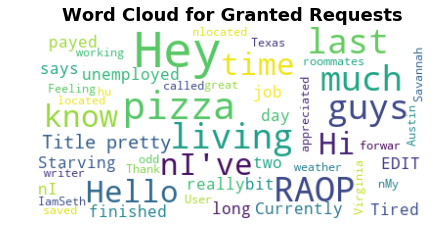

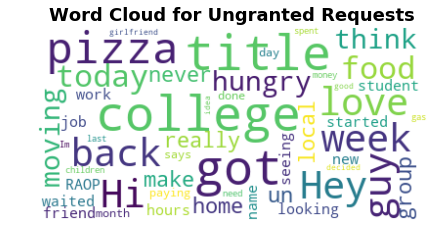

In [8]:
from wordcloud import WordCloud, STOPWORDS
granted = train[train['requester_received_pizza']==True]
ungranted = train[train['requester_received_pizza']==False]

plt.rcParams['font.size']=12        
plt.rcParams['savefig.dpi']=100         
plt.rcParams['figure.subplot.bottom']=.1 

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(granted['request_text_edit_aware']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Granted Requests",fontsize=18, fontweight='bold')
plt.show()

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(ungranted['request_text_edit_aware']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Ungranted Requests",fontsize=18, fontweight='bold')
plt.show()

We create a histogram for all the numeric fields present in the train dataset. For most numeric fields we see a positive skewed distribution. 

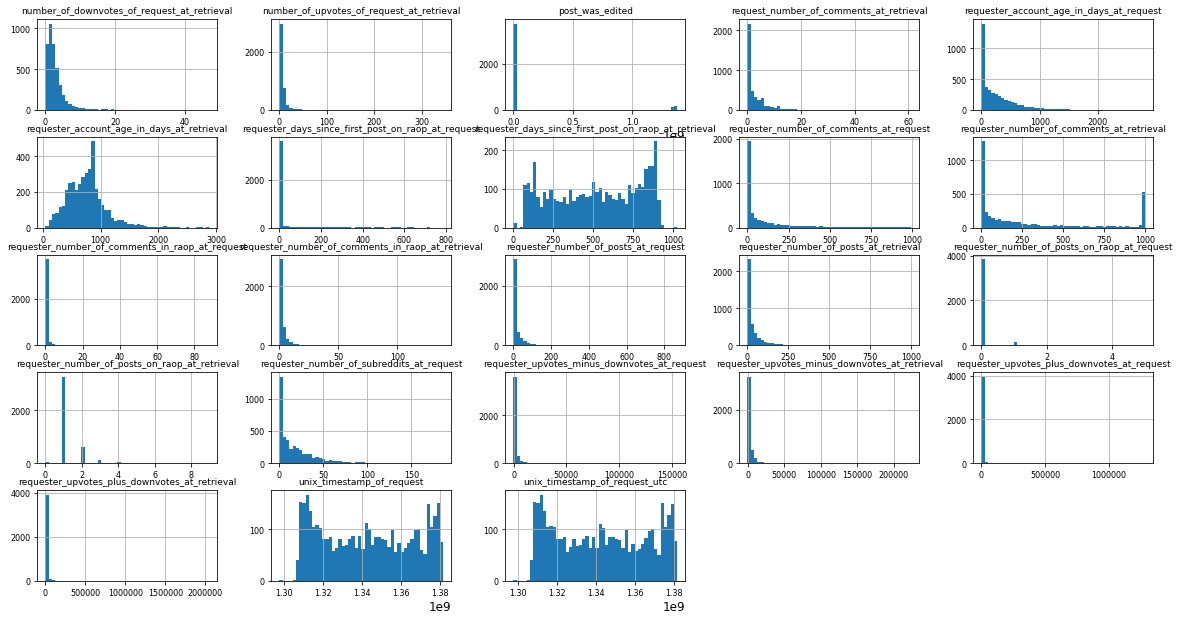

In [9]:
df_num = (train.select_dtypes(include = ['float64', 'int64']))  #All columns are numeric
df_num.shape 

fig = df_num.hist(figsize=(20, 10), bins=50, xlabelsize=8, ylabelsize=8)
fig = [x.title.set_size(9) for x in fig.ravel()]
fig;

In [10]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (4040, 32)
Test shape: (1631, 17)


In [11]:
# Print out columns that are only in the train dataset
train_only_columns = set(train.columns.values)-set(test.columns.values)
print("Columns in Train but not Test:\n",train_only_columns)

Columns in Train but not Test:
 {'number_of_downvotes_of_request_at_retrieval', 'requester_account_age_in_days_at_retrieval', 'requester_number_of_posts_on_raop_at_retrieval', 'request_number_of_comments_at_retrieval', 'requester_received_pizza', 'requester_user_flair', 'requester_upvotes_plus_downvotes_at_retrieval', 'number_of_upvotes_of_request_at_retrieval', 'requester_number_of_comments_at_retrieval', 'post_was_edited', 'requester_days_since_first_post_on_raop_at_retrieval', 'requester_upvotes_minus_downvotes_at_retrieval', 'requester_number_of_posts_at_retrieval', 'requester_number_of_comments_in_raop_at_retrieval', 'request_text'}


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4040 entries, 0 to 4039
Data columns (total 32 columns):
giver_username_if_known                                 4040 non-null object
number_of_downvotes_of_request_at_retrieval             4040 non-null int64
number_of_upvotes_of_request_at_retrieval               4040 non-null int64
post_was_edited                                         4040 non-null int64
request_id                                              4040 non-null object
request_number_of_comments_at_retrieval                 4040 non-null int64
request_text                                            4040 non-null object
request_text_edit_aware                                 4040 non-null object
request_title                                           4040 non-null object
requester_account_age_in_days_at_request                4040 non-null float64
requester_account_age_in_days_at_retrieval              4040 non-null float64
requester_days_since_first_post_on_raop_at_reque

We further combine the text columns into a single column, and remove punctuation marks.

In [17]:
#combining all text to one column
train['text'] = train['request_title'].map(str) + ' ' + train['request_text']
train1 = train.copy(deep = True)
#remove punctuation
tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))
def remove_punctuation(text):
    return text.translate(tbl) 

train1['text'] = train1['text'].apply( lambda x: remove_punctuation(x))
train1['text'].head(4)

0    Request Colorado Springs Help Us Please Hi I a...
1    Request California No cash and I could use som...
2    Request Hungry couple in Dundee Scotland would...
3    Request In Canada Ontario just got home from s...
Name: text, dtype: object

## Clustering
We perform k-means clustering, with number of clusters as 4, and max iterations as 100.

In [18]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1,random_state=5)
vectorizer = TfidfVectorizer(min_df = 0.05, max_df=0.95,
                             ngram_range=(1, 2), 
                             stop_words='english')

In [19]:
tfidf_features = vectorizer.fit_transform(train1['text'].values.astype('U'))
vocab = vectorizer.get_feature_names()
sse_err = []
res = kmeans.fit(tfidf_features)
vocab = np.array(vocab)
cluster_centers = np.array(res.cluster_centers_)
sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]
words=set()
vocab

array(['able', 'account', 'ago', 'appreciate', 'appreciated', 'away',
       'awesome', 'bad', 'bank', 'bills', 'bit', 'broke', 'buy', 'car',
       'cash', 'college', 'college student', 'come', 'couple', 'day',
       'days', 'dinner', 'dont', 'eat', 'eating', 'edit', 'family',
       'feel', 'food', 'forward', 'friday', 'friend', 'friends',
       'getting', 'going', 'good', 'got', 'great', 'guys', 'havent',
       'having', 'help', 'hey', 'home', 'house', 'hungry', 'id', 'ill',
       'im', 'ive', 'job', 'just', 'kind', 'know', 'left', 'like',
       'little', 'live', 'living', 'long', 'looking', 'lost', 'love',
       'love pizza', 'make', 'meal', 'money', 'month', 'months', 'moved',
       'need', 'new', 'nice', 'night', 'old', 'paid', 'past', 'pay',
       'pay forward', 'people', 'pizza', 'post', 'pretty', 'ramen',
       'reading', 'really', 'recently', 'reddit', 'rent', 'request',
       'request pizza', 'return', 'right', 'school', 'send', 'soon',
       'story', 'student', '

In [20]:
for i in range(len(res.cluster_centers_)):
    words = words.union(set(vocab[sorted_vals[i][-10:]]))
words=list(words)
print(words)

['like', 'pizza', 'week', 'work', 'broke', 'request', 'help', 'dont', 'money', 'im', 'hungry', 'pay', 'job', 'college student', 'tonight', 'college', 'thanks', 'really', 'just', 'love pizza', 'food', 'ive', 'love', 'student']


## Model Building

## Model 0 Naive Model

In [21]:
train["NoOneGetsAPizza"] = 0
train.loc[train['requester_received_pizza']==train['NoOneGetsAPizza'], 'Accuracy'] = 1
train.loc[train['requester_received_pizza']!=train['NoOneGetsAPizza'], 'Accuracy'] = 0
acctrain=(sum(train['Accuracy'])/train.shape[0])*100
print("Naive Train Accuracy:",acctrain)
from sklearn.metrics import roc_auc_score
y_true = np.array(train['requester_received_pizza'])
y_pred = np.array(train['NoOneGetsAPizza'])
roc_auc_score(y_true, y_pred)
print("AUC:",acctrain)

Naive Train Accuracy: 75.39603960396039
AUC: 75.39603960396039


## Model #1

I have used Logistic Regression with cross validation as the data model. Overfitting is prevented by using cross validation. The best parameters for cross validation are found by using grid search method.

In [22]:
def train_test_plot(X_train, X_test, y_train, y_test):
    # Grid search to find best parameteres
    gs = grid_search.GridSearchCV(
        estimator=LogisticRegression(),
        param_grid={'C': [10**-i for i in range(-5, 5)], 'class_weight': [None, 'balanced']},
        cv=cross_validation.StratifiedKFold(y_train,n_folds=10),
        scoring='roc_auc'
    )
    start = time.clock()
    gs.fit(X_train, y_train)
    end = time.clock()
    print ("Grid Search Fitting time : %s seconds" % (end - start))
    
    print('Best Estimator:', gs.best_estimator_)
    
    probas = gs.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas[:,1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return


Next we will select the TFIDF features that are part of the vocabulary that we found using kmeans clustering, make a train, test split, then use our helper function to observe the results. We add the top words to X features and split the data in 90:10 ratio before passing on to the model function.

Grid Search Fitting time : 2.4591980000000007 seconds
Best Estimator: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


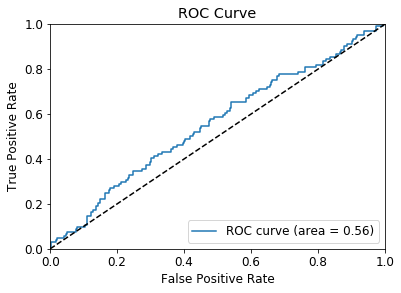

In [23]:
#add top words to X features.
X = tfidf_features[:,[np.argwhere(vocab==i)[0][0] for i in words]]
y = train['requester_received_pizza']

# Split up the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Pass to Helper Function
train_test_plot(X_train, X_test, y_train, y_test)

## Model Improvement

## Model #2

We had identified a continuous features that had a 0.46, and 0.27 correlation with the requester_recieved_pizza target. Let's see the effect of adding these into the feature set.


Grid Search Fitting time : 11.038196000000001 seconds
Best Estimator: LogisticRegression(C=100000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


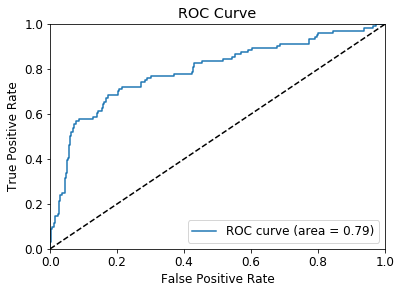

In [18]:

# Add new features to feature set.
new_feat_list = ['requester_number_of_comments_in_raop_at_retrieval',
                 'requester_number_of_posts_on_raop_at_retrieval']

new_feat = train[new_feat_list]
new_X = pd.DataFrame(X.todense()).join(new_feat)

# Create scaler
scaler = StandardScaler()

# Scale the features
new_X_scaled = scaler.fit_transform(new_X)

# Split up the data
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(new_X_scaled, y, test_size=0.10, random_state=42)

# Pass to helper function
train_test_plot(X_train_scaled, X_test_scaled, y_train, y_test)


## Model #3
We also add the other features to the dataset and observe similar results.

Grid Search Fitting time : 50.84866099999999 seconds
Best Estimator: LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


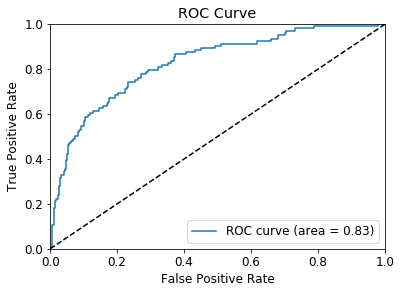

In [19]:
new_feat_list = cont_features
new_feat = train[new_feat_list]
new_X = pd.DataFrame(X.todense()).join(new_feat)

# Create scaler
scaler = StandardScaler()

# Scale the features
new_X_scaled = scaler.fit_transform(new_X)

# Split up the data
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(new_X_scaled, y, test_size=0.10, random_state=42)

# Pass to helper function
train_test_plot(X_train_scaled, X_test_scaled, y_train, y_test)
